### Image Augmentation and StepLR Scheduler

##### Target:
1. Added Image augmentation - Random rotation of in the range of -15 to 15 degrees and fill with 1
1. Increase the Learning Rate to 0.1 for faster convergence
2. Add StepLR to decrease the Learning rate. Keep the Step size = 11 and Gamma = 0.2

##### Results:
1. Parameters: 7612
2. Best Train Accuracy: 99.16%
3. Best Test Accuracy: 99.44%

##### Analysis:
1. Image augmentation regularized the model as overfitting issue got resolved..
2. The intuition behind above LR values is, that the accuracy is gradually increasing till around 10 epochs and getting stall from there.
3. Decreasing the speed a little bit after 11 epochs by a factor of 0.2
4. Tried these StepSize and Gamma combinations - (10, 0.2), (11, 0.2), (12, 0.2)
5. Finally Stepsize=11, Gamma=0.2 gave best consistency of >=99.4% in the last 3 epochs and hit maximum of 99.44% with less than 8000 parameters

### import Libraries

In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import matplotlib.pyplot as plt

### Data Statics

In [12]:
simple_transforms = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST('./data',train = True,transform=simple_transforms,download=True)
exp_data = dataset.train_data
exp_data = dataset.transform(exp_data.numpy())

print('[Train]')
print('-Numpy Shape:',dataset.train_data.cpu().numpy().shape)
print('-Tensor Shape:',dataset.train_data.size())
print('-min:',torch.min(exp_data))
print('-max:',torch.max(exp_data))
print('-mean:',torch.mean(exp_data))
print('-std:',torch.std(exp_data))
print('-var:',torch.var(exp_data))

[Train]
-Numpy Shape: (60000, 28, 28)
-Tensor Shape: torch.Size([60000, 28, 28])
-min: tensor(0.)
-max: tensor(1.)
-mean: tensor(0.1307)
-std: tensor(0.3081)
-var: tensor(0.0949)


 ### Data Transformation

 We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [13]:
train_transforms = transforms.Compose([
    transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

### Create Train and Test Data

In [14]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

### Dataloader Arguments

In [15]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### The Model Architecture

In [16]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=8)
    ) #Input size = 28, Output Size = 26, RFout = 3

    #Convolution Block 1
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=16)
    ) #Input size = 26, Output Size = 24, RFout = 5

    #Transition Block 1
    self.pool1 = nn.MaxPool2d(2,2) #Input size = 24, Output Size = 12, RFout = 6
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=8)
    )#Input size = 12, Output Size = 12, RFout = 6

    #Convolution Block 2
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=16)
    )#Input size = 12, Output Size = 10, RFout = 10
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32)
    )#Input size = 10, Output Size = 8, RFout = 14

    #Output block
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=10,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=10)
    )#Input size = 8, Output Size = 8, RFout = 14
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=(8,8))
    )#Input size = 8, Output Size = 1, RFout = 28

  def forward(self,x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

### Check the model parameters

In [17]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
              ReLU-9            [-1, 8, 12, 12]               0
      BatchNorm2d-10            [-1, 8, 12, 12]              16
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
           Conv2d-14             [

Training and Testing

In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### Train the Model

In [19]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 15
scheduler = StepLR(optimizer, step_size=11, gamma=0.2)
#scheduler = ReduceLROnPlateau(optimizer, 'max',patience=1,factor=0.2)

for epoch in range(EPOCHS):
    print(f" ***** EPOCH:{epoch} ***** ")
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)
    #scheduler.step(test_acc[-1])
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate after epoch {epoch}: {current_lr:.6f}")

 ***** EPOCH:0 ***** 


Loss=0.11997572332620621 Batch_id=468 Accuracy=92.81: 100%|██████████| 469/469 [00:05<00:00, 86.33it/s] 



Test set: Average loss: 0.0748, Accuracy: 9798/10000 (97.98%)

Learning Rate after epoch 0: 0.100000
 ***** EPOCH:1 ***** 


Loss=0.10430850833654404 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:05<00:00, 86.58it/s] 



Test set: Average loss: 0.0593, Accuracy: 9834/10000 (98.34%)

Learning Rate after epoch 1: 0.100000
 ***** EPOCH:2 ***** 


Loss=0.11033850163221359 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:05<00:00, 85.45it/s] 



Test set: Average loss: 0.0432, Accuracy: 9874/10000 (98.74%)

Learning Rate after epoch 2: 0.100000
 ***** EPOCH:3 ***** 


Loss=0.030675305053591728 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:05<00:00, 86.72it/s]



Test set: Average loss: 0.0433, Accuracy: 9866/10000 (98.66%)

Learning Rate after epoch 3: 0.100000
 ***** EPOCH:4 ***** 


Loss=0.10368446260690689 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:05<00:00, 86.29it/s] 



Test set: Average loss: 0.0348, Accuracy: 9894/10000 (98.94%)

Learning Rate after epoch 4: 0.100000
 ***** EPOCH:5 ***** 


Loss=0.06590408831834793 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:05<00:00, 88.69it/s] 



Test set: Average loss: 0.0345, Accuracy: 9889/10000 (98.89%)

Learning Rate after epoch 5: 0.100000
 ***** EPOCH:6 ***** 


Loss=0.026078181341290474 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:05<00:00, 85.66it/s]



Test set: Average loss: 0.0309, Accuracy: 9910/10000 (99.10%)

Learning Rate after epoch 6: 0.100000
 ***** EPOCH:7 ***** 


Loss=0.0344075933098793 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:05<00:00, 84.13it/s]  



Test set: Average loss: 0.0357, Accuracy: 9892/10000 (98.92%)

Learning Rate after epoch 7: 0.100000
 ***** EPOCH:8 ***** 


Loss=0.0647762343287468 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:05<00:00, 85.45it/s]  



Test set: Average loss: 0.0311, Accuracy: 9912/10000 (99.12%)

Learning Rate after epoch 8: 0.100000
 ***** EPOCH:9 ***** 


Loss=0.032781146466732025 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:05<00:00, 85.82it/s] 



Test set: Average loss: 0.0278, Accuracy: 9914/10000 (99.14%)

Learning Rate after epoch 9: 0.100000
 ***** EPOCH:10 ***** 


Loss=0.058401212096214294 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:05<00:00, 86.03it/s] 



Test set: Average loss: 0.0272, Accuracy: 9920/10000 (99.20%)

Learning Rate after epoch 10: 0.020000
 ***** EPOCH:11 ***** 


Loss=0.07839225977659225 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:05<00:00, 86.12it/s]  



Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

Learning Rate after epoch 11: 0.020000
 ***** EPOCH:12 ***** 


Loss=0.01562392245978117 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:05<00:00, 85.84it/s]  



Test set: Average loss: 0.0209, Accuracy: 9944/10000 (99.44%)

Learning Rate after epoch 12: 0.020000
 ***** EPOCH:13 ***** 


Loss=0.016007820144295692 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:05<00:00, 87.17it/s] 



Test set: Average loss: 0.0204, Accuracy: 9944/10000 (99.44%)

Learning Rate after epoch 13: 0.020000
 ***** EPOCH:14 ***** 


Loss=0.07563576102256775 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:05<00:00, 84.86it/s]  



Test set: Average loss: 0.0205, Accuracy: 9942/10000 (99.42%)

Learning Rate after epoch 14: 0.020000


### Loss and Accuracy Plot

Text(0.5, 1.0, 'Test Accuracy')

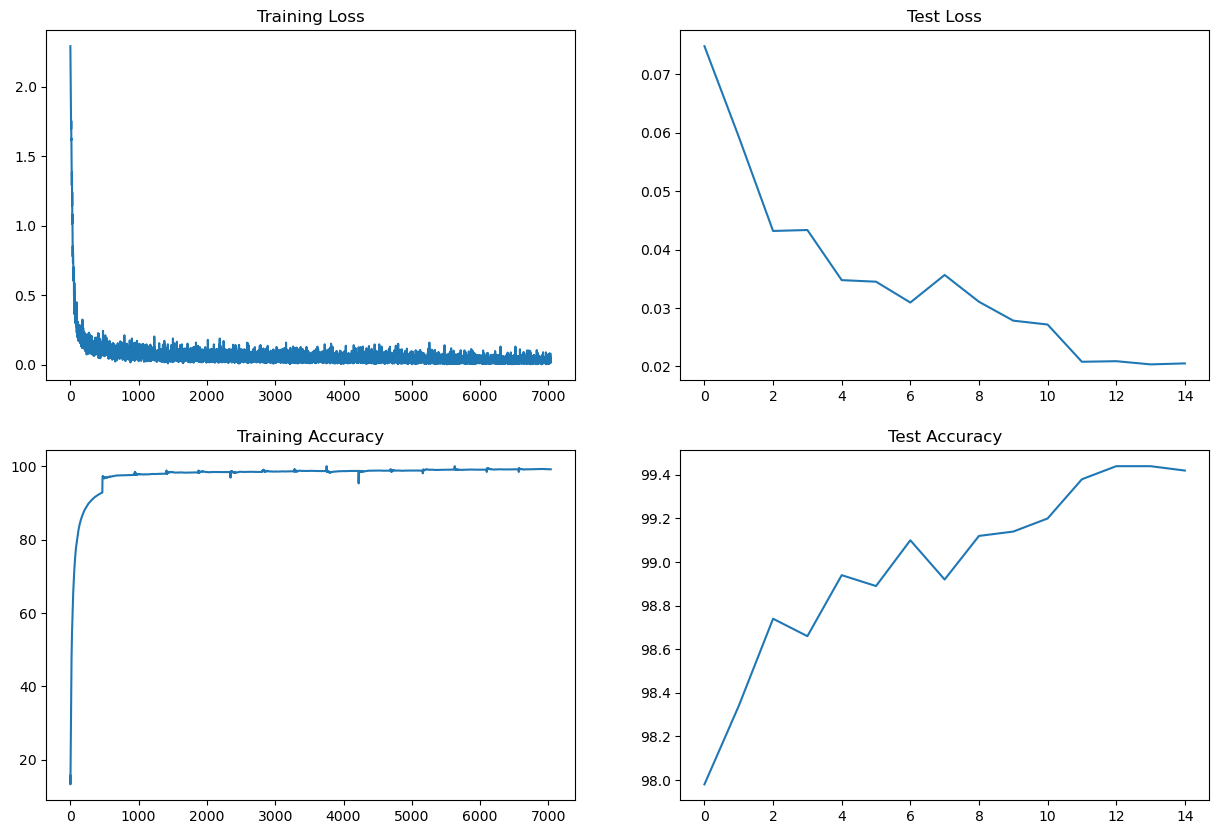

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# Move tensors to CPU and convert to NumPy
train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
train_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in train_acc]
test_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in test_losses]
test_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in test_acc]

axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_cpu)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_cpu)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_cpu)
axs[1, 1].set_title("Test Accuracy")